In [1]:
import json
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
train_inst = json.load(open('D:/Machine Learning/Global Wheat Detection Challenge/Data/train_instances.json', 'r'))

In [2]:
all_bbox = []
for inst in tqdm(train_inst):
    for box in inst['BBox']:
        all_bbox.append(box+[box[2]- box[0], box[3]-box[1], (box[0] +box[2])*0.5, (box[1]+box[3])*0.5])
all_bbox= np.array(all_bbox)
print(all_bbox.shape)

100%|███████████████████████████████████████████████████████████████████████████| 3373/3373 [00:00<00:00, 10340.44it/s]

(147792, 8)


In [19]:
df = pd.DataFrame(all_bbox, columns = ['x_min', 'y_min', 'x_max', 'y_max', 'Width', 'Height', 'x_center', 'y_center'], dtype = np.uint16)
df.describe()

,x_min,y_min,x_max,y_max,Width,Height,x_center,y_center
count,147792.000000,147792.000000,147792.000000,147792.000000,147792.000000,147792.000000,147792.000000,147792.000000
mean,472.378187,475.384392,556.813109,552.311715,84.434110,76.926491,514.345871,513.597935
std,303.554826,300.815536,302.304731,298.944827,35.553299,33.853687,302.408410,299.404423
min,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000
25%,203.000000,213.000000,292.000000,294.000000,62.000000,55.000000,247.000000,253.000000
50%,475.000000,477.000000,563.000000,556.000000,78.000000,71.000000,518.000000,516.000000
75%,737.000000,737.000000,823.000000,814.000000,100.000000,91.000000,780.000000,775.000000
max,1023.000000,1023.000000,1024.000000,1024.000000,987.000000,714.000000,1023.000000,1023.000000


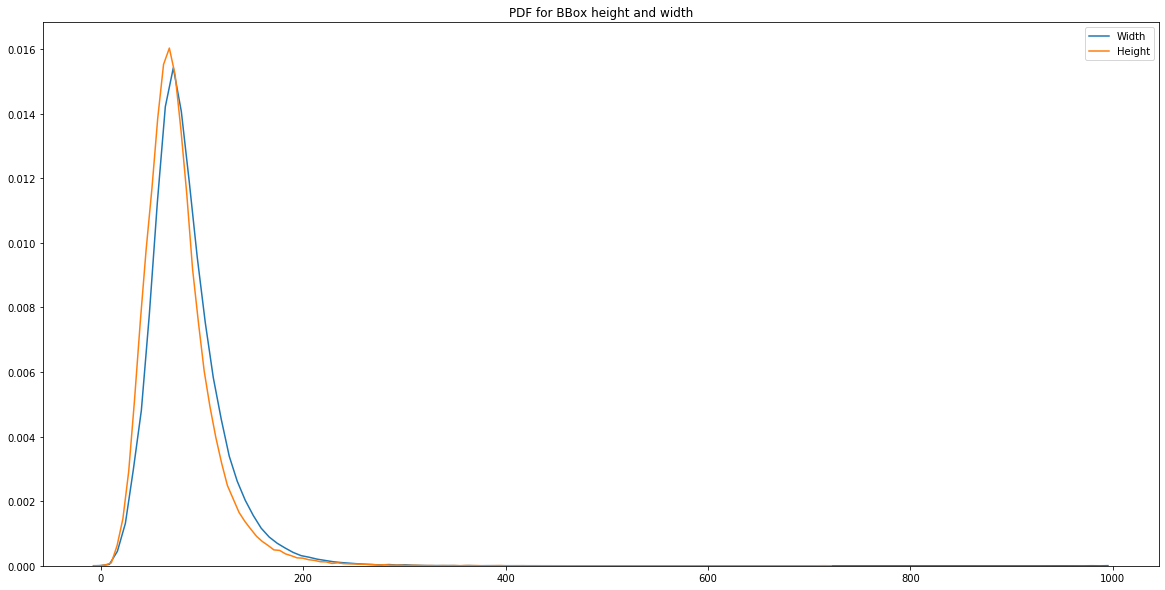

In [39]:
plt.figure(figsize = (20, 10))
sns.kdeplot(data = all_bbox[:, 2], Label = 'Width')
sns.kdeplot(data = all_bbox[:, 3], Label = 'Height')
plt.title('PDF for BBox height and width')
plt.legend()

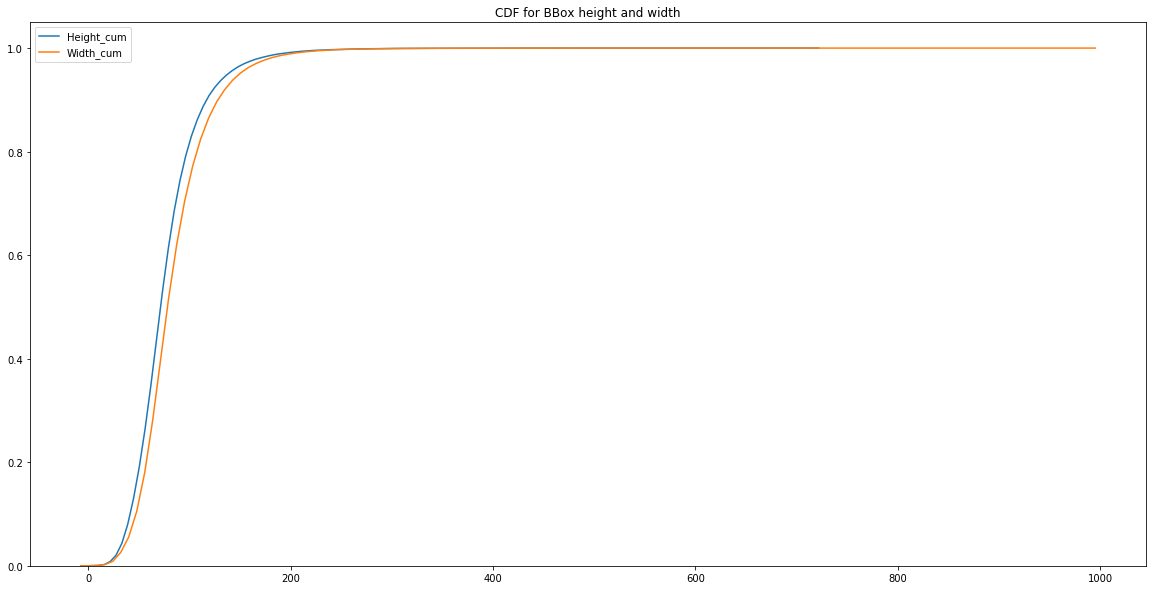

In [38]:
plt.figure(figsize = (20, 10))
sns.kdeplot(data = all_bbox[:, 3], Label = 'Height_cum', cumulative = True)
sns.kdeplot(data = all_bbox[:, 2], Label = 'Width_cum', cumulative = True)
plt.title('CDF for BBox height and width')
plt.legend()

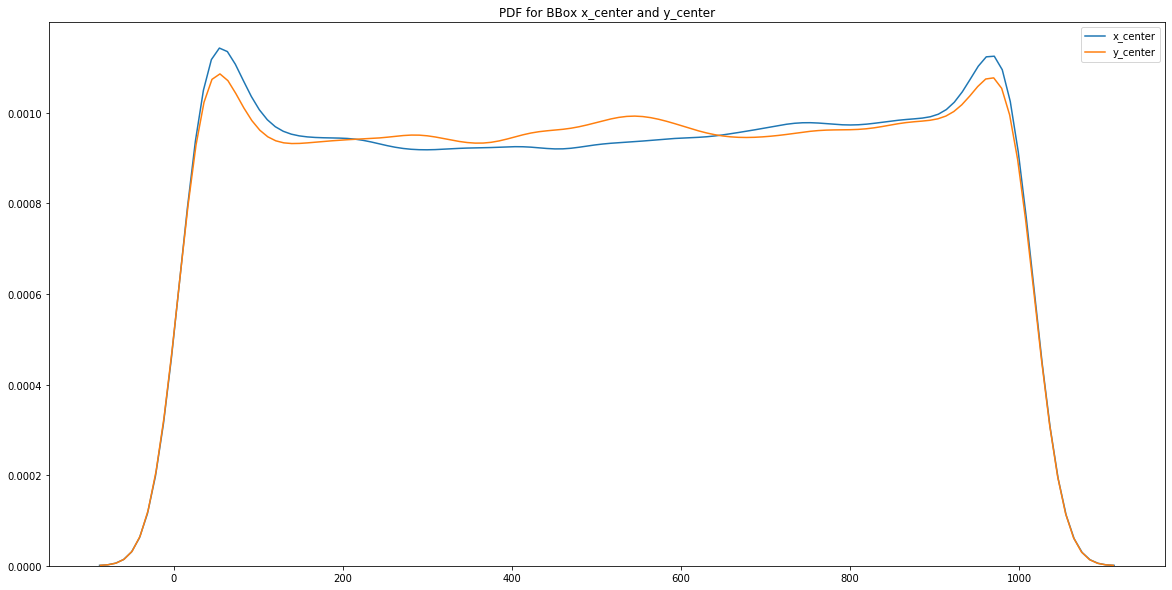

In [61]:
plt.figure(figsize = (20, 10))
sns.kdeplot(data = df['x_center'], Label = 'x_center')
sns.kdeplot(data = df['y_center'], Label = 'y_center')
plt.title('PDF for BBox x_center and y_center')
plt.legend()

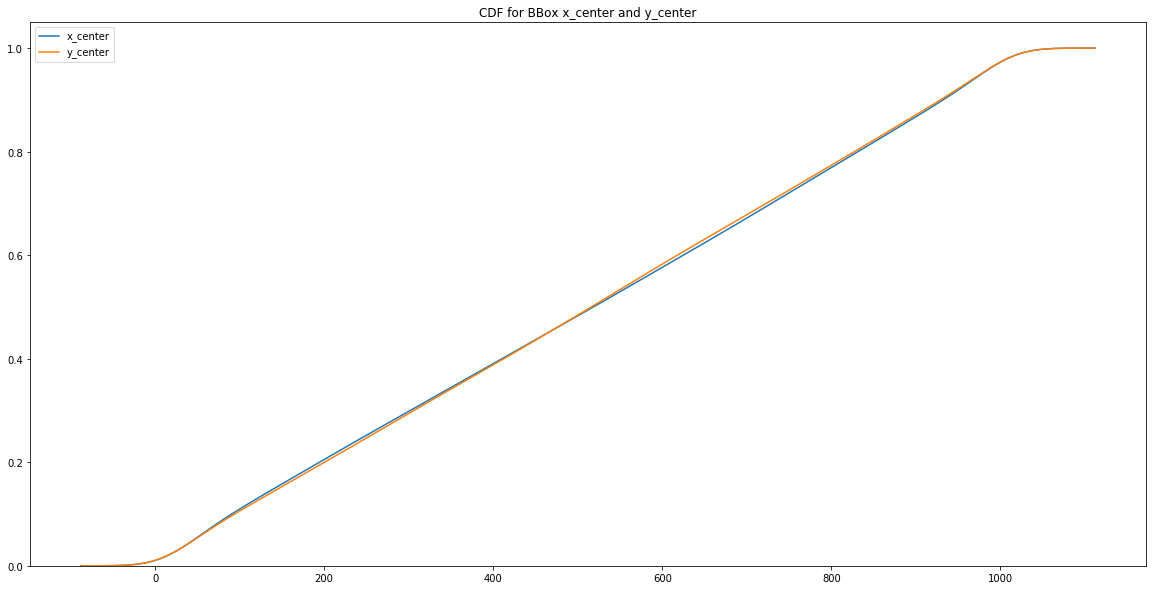

In [62]:
plt.figure(figsize = (20, 10))
sns.kdeplot(data = df['x_center'], Label = 'x_center', cumulative = True)
sns.kdeplot(data = df['y_center'], Label = 'y_center', cumulative = True)
plt.title('CDF for BBox x_center and y_center')
plt.legend()

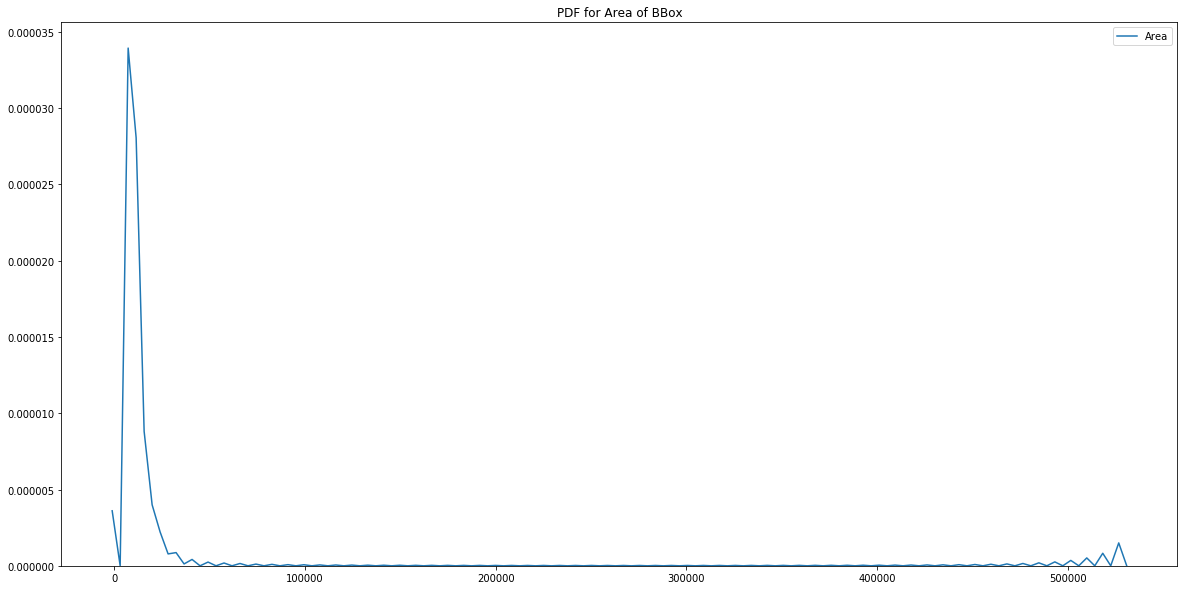

In [40]:
Area = all_bbox[:, 2]*all_bbox[:, 3]
plt.figure(figsize = (20, 10))
sns.kdeplot(data = Area, Label = 'Area')
plt.title('PDF for Area of BBox')
plt.legend()

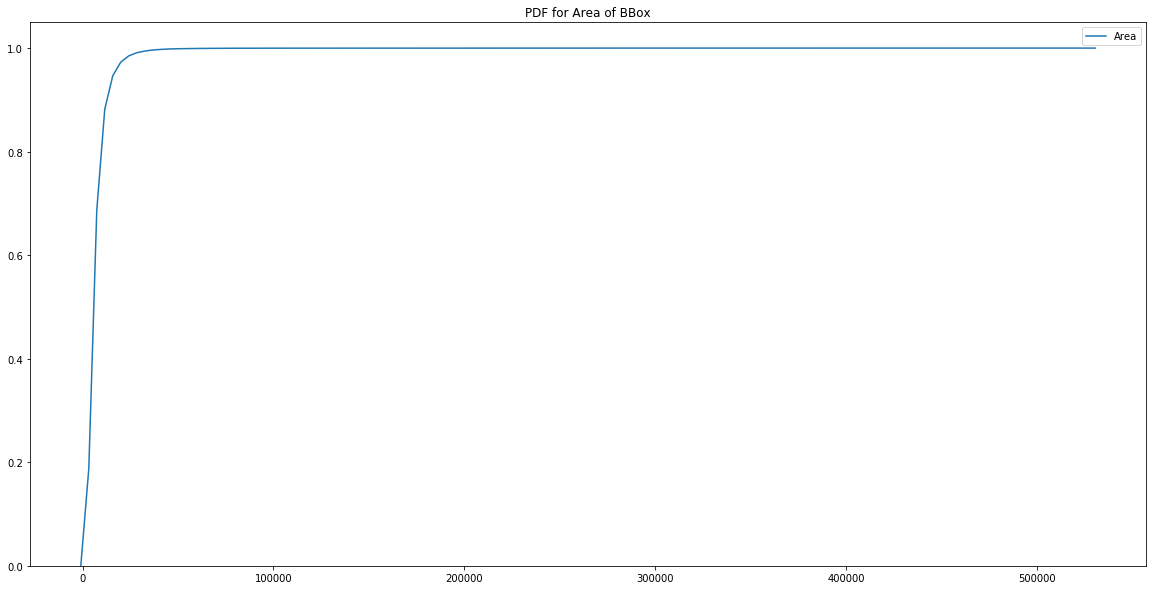

In [42]:
Area = all_bbox[:, 2]*all_bbox[:, 3]
plt.figure(figsize = (20, 10))
sns.kdeplot(data = Area, Label = 'Area', cumulative = True)
plt.title('PDF for Area of BBox')
plt.legend()

<Figure size 1440x720 with 0 Axes>

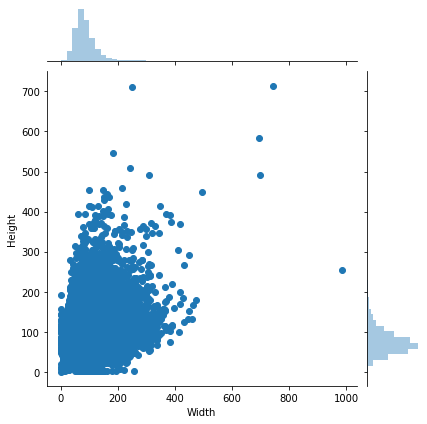

In [59]:
plt.figure(figsize = (20, 10))
sns.jointplot(x = df['Width'], y = df['Height'])


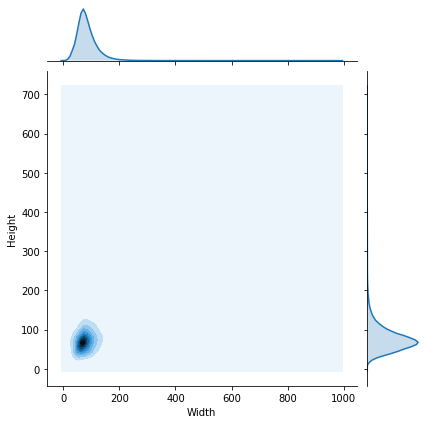

In [63]:
sns.jointplot(x = df['Width'], y = df['Height'], kind = 'kde')

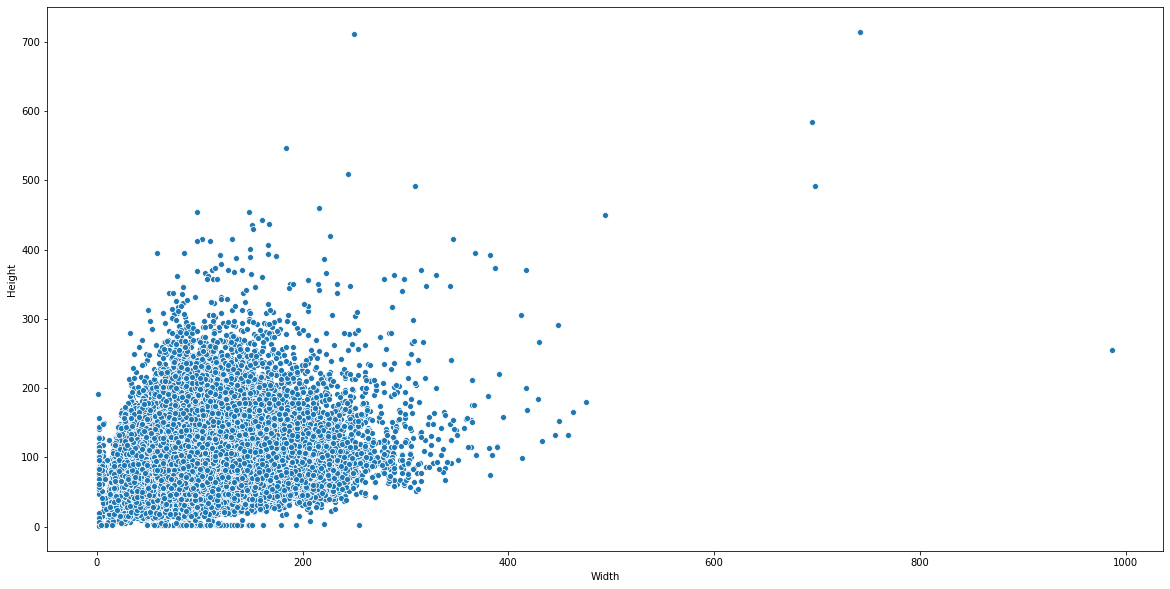

In [66]:
plt.figure(figsize = (20, 10))
sns.scatterplot(df['Width'], df['Height'])

In [69]:
from sklearn.cluster import DBSCAN
model = DBSCAN(n_jobs = -1)
model.fit(df[['Width', 'Height']])

DBSCAN(n_jobs=-1)

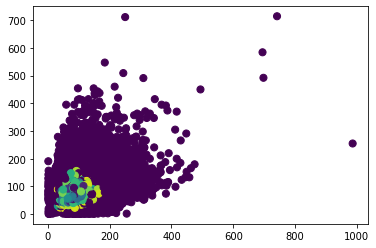

In [77]:
plt.scatter(df['Width'], df['Height'], c=model.labels_,
            s=50, cmap='viridis');

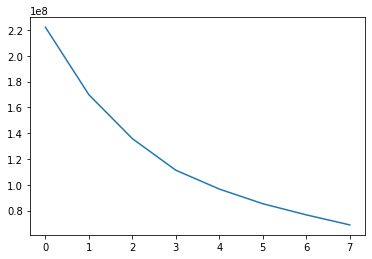

In [82]:
from sklearn.cluster import KMeans
loss = []
from sklearn.cluster import KMeans
for i in range(2,10):
    model = KMeans(i, random_state=1)
    labels = model.fit(df[['Width', 'Height']])
    loss.append(labels.inertia_)
plt.plot(loss)

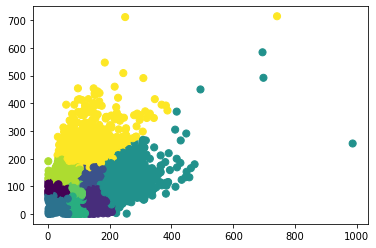

In [83]:
model = KMeans(9, random_state=1)
model.fit(df[['Width', 'Height']])
plt.scatter(df['Width'], df['Height'], c=model.labels_,
            s=50, cmap='viridis');

In [86]:
model.cluster_centers_

array([[ 58.1843145 ,  78.50240427],
       [134.28266627,  66.02702723],
       [129.49731486, 120.77672879],
       [ 51.91842628,  46.56957023],
       [214.19511938, 109.15926966],
       [ 86.44960136,  51.93200454],
       [ 91.68646293,  85.62212155],
       [ 73.48417068, 127.84991092],
       [120.37864119, 213.18806794]])

In [10]:
import sys
def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)

def initialize(data, k): 
    ''' 
    initialized the centroids for K-means++ 
    inputs: 
        data - numpy array of data points having shape (200, 2) 
        k - number of clusters  
    '''
    ## initialize the centroids list and add 
    ## a randomly selected data point to the list 
    centroids = [] 
    centroids.append(data[np.random.randint( 
            data.shape[0]), :]) 
#     plot(data, np.array(centroids)) 
   
    ## compute remaining k - 1 centroids 
    for c_id in range(k - 1): 
          
        ## initialize a list to store distances of data 
        ## points from nearest centroid 
        dist = [] 
        for i in range(data.shape[0]): 
            point = data[i, :] 
            d = sys.maxsize 
              
            ## compute distance of 'point' from each of the previously 
            ## selected centroid and store the minimum distance 
            for j in range(len(centroids)): 
                temp_dist = distance(point, centroids[j]) 
                d = min(d, temp_dist) 
            dist.append(d) 
              
        ## select data point with maximum distance as our next centroid 
        dist = np.array(dist) 
        next_centroid = data[np.argmax(dist), :] 
        centroids.append(next_centroid) 
        dist = [] 
#         plot(data, np.array(centroids)) 
    return centroids 
def distance(p1, p2): 
    return np.sum((p1 - p2)**2) 

def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = np.array(initialize(boxes, k))

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

cl = kmeans(np.array(df[['Width', 'Height']]), 9)
print(cl)

[[ 49.  39.]
 [104.  64.]
 [ 82. 102.]
 [113. 146.]
 [ 75.  75.]
 [ 61.  58.]
 [ 86.  43.]
 [134.  89.]
 [ 45.  82.]]


In [11]:
boxes = np.array(df[['Width', 'Height']])
distances = np.empty((boxes.shape[0], 9))
for row in range(boxes.shape[0]):
    distances[row] = 1- iou(boxes[row], cl)
labels = np.argmin(distances, axis = 1)

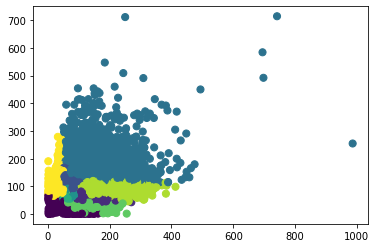

In [12]:
plt.scatter(df['Width'], df['Height'], c=labels,
            s=50, cmap='viridis')
plt.savefig('kmeans_iou.png')

In [13]:
sorted(zip(cl[:, 0]*cl[:, 1], cl))

[(1911.0, array([49., 39.])),
 (3538.0, array([61., 58.])),
 (3690.0, array([45., 82.])),
 (3698.0, array([86., 43.])),
 (5625.0, array([75., 75.])),
 (6656.0, array([104.,  64.])),
 (8364.0, array([ 82., 102.])),
 (11926.0, array([134.,  89.])),
 (16498.0, array([113., 146.]))]

In [14]:
np.array(df[['Width', 'Height']], dtype = np.uint16)

array([[ 56,  36],
       [130,  58],
       [ 74, 160],
       ...,
       [107,  82],
       [141,  71],
       [184,  79]], dtype=uint16)

In [23]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters = 9)
model.fit(X = df[['Width', 'Height']])

MemoryError: Unable to allocate 81.4 GiB for an array with shape (10921163736,) and data type float64

In [109]:
f = model.cluster_centers_
sorted(zip(f[:, 0]*f[:,1], f))

[(2417.8187986028875, array([51.91842628, 46.56957023])),
 (4489.50108996658, array([86.44960136, 51.93200454])),
 (4567.608579417832, array([58.1843145 , 78.50240427])),
 (7850.389473641589, array([91.68646293, 85.62212155])),
 (8866.285262063393, array([134.28266627,  66.02702723])),
 (9394.944674935821, array([ 73.48417068, 127.84991092])),
 (15640.262075728335, array([129.49731486, 120.77672879])),
 (23381.38279710387, array([214.19511938, 109.15926966])),
 (25663.289936383284, array([120.37864119, 213.18806794]))]